<a href="https://colab.research.google.com/github/unicamp-dl/IA025_2022S1/blob/main/ex05/Gustavo_Arantes/Atividade_05_IA025A_Gustavo_Arantes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
nome = 'Gustavo da Silva Arantes'
print(f'Meu nome é {nome}')

Meu nome é Gustavo da Silva Arantes


# Inspiração no código do colega: Bruno Rangel Balbino dos Santos

Este exercicío consiste em treinar no MNIST um modelo de umas camadas, sendo a primeira uma camada convolucional e a segunda uma camada linear de classificação.

Não podemos usar as funções torch.nn.Conv{1,2,3}d

## Importação das bibliotecas

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torchvision
from torchvision.datasets import MNIST

## Fixando as seeds

In [3]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

## Define pesos iniciais

In [95]:
in_channels = 1
out_channels = 2
kernel_size = 5
stride = 3

# Input image size
height_in = 28  
width_in = 28

# Image size after the first convolutional layer.
height_out = (height_in - kernel_size) // stride + 1
width_out = (width_in - kernel_size) // stride + 1

initial_conv_weight = torch.FloatTensor(out_channels, in_channels, kernel_size, kernel_size).uniform_(-0.01, 0.01)
initial_conv_bias = torch.FloatTensor(out_channels,).uniform_(-0.01, 0.01)

initial_classification_weight = torch.FloatTensor(10, out_channels * height_out * width_out).uniform_(-0.01, 0.01)
initial_classification_bias = torch.FloatTensor(10,).uniform_(-0.01, 0.01)

## Dataset e dataloader

### Definição do tamanho do minibatch

In [5]:
batch_size = 50

### Carregamento, criação dataset e do dataloader

In [6]:
dataset_dir = '../data/'

dataset_train_full = MNIST(dataset_dir, train=True, download=True,
                           transform=torchvision.transforms.ToTensor())
print(dataset_train_full.data.shape)
print(dataset_train_full.targets.shape)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

torch.Size([60000, 28, 28])
torch.Size([60000])


### Usando apenas 1000 amostras do MNIST

Neste exercício utilizaremos 1000 amostras de treinamento.

In [7]:
indices = torch.randperm(len(dataset_train_full))[:1000]
dataset_train = torch.utils.data.Subset(dataset_train_full, indices)

## Define os pesos iniciais

In [8]:
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=False)

In [9]:
print('Número de minibatches de trenamento:', len(loader_train))

x_train, y_train = next(iter(loader_train))
print("\nDimensões dos dados de um minibatch:", x_train.size())
print("Valores mínimo e máximo dos pixels: ", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:         ", type(x_train))
print("Tipo das classes das imagens:       ", type(y_train))

Número de minibatches de trenamento: 20

Dimensões dos dados de um minibatch: torch.Size([50, 1, 28, 28])
Valores mínimo e máximo dos pixels:  tensor(0.) tensor(1.)
Tipo dos dados das imagens:          <class 'torch.Tensor'>
Tipo das classes das imagens:        <class 'torch.Tensor'>


## Camada Convolucional

In [92]:
class MyConv2d(torch.nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, stride: int):
        super(MyConv2d, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size  # The same for height and width.
        self.stride = stride  # The same for height and width.
        self.weight = torch.nn.Parameter(torch.FloatTensor(out_channels, in_channels, kernel_size, kernel_size).uniform_(-0.01, 0.01))
        self.bias = torch.nn.Parameter(torch.FloatTensor(out_channels,).uniform_(-0.01, 0.01))

    def forward(self, x):
        assert x.dim() == 4, f'x must have 4 dimensions: {x.shape}'
        # Escreva seu código aqui.
        
        width  = (x.shape[3]-1*(self.kernel_size-1)-1)//self.stride+1
        height = (x.shape[2]-1*(self.kernel_size-1)-1)//self.stride+1

        output =   torch.zeros((x.shape[0], self.out_channels,width, height))
        if self.kernel_size%2 ==0:
          output = torch.zeros((x.shape[0], self.out_channels,x.shape[2]- ((self.weight.data.shape[2]//2)), x.shape[3]- ((self.weight.data.shape[3]//2))))
          for k in range(self.out_channels):
            for i in range(output.shape[2]):
              for j in range(output.shape[3]):
                output[:, :,i,j]=(self.weight.data[:,k] *x[:,k,i: i+self.kernel_size, j: j+self.kernel_size]).sum() # multiplicação ponto a ponto pelo tamanho do kernel

        else:
         for ni1 in range(x.shape[0]):
           for k1 in range(x.shape[1]):
             l = 0
             for i1 in range((self.kernel_size-1)//2,x.shape[2]-(self.kernel_size-1)//2,self.stride):
               c = 0
               for j1 in range((self.kernel_size-1)//2,x.shape[3]-(self.kernel_size-1)//2,self.stride):
                  formul = (self.weight* x[ni1,k1,i1-(self.kernel_size-1)//2: i1+1+(self.kernel_size-1)//2, j1-(self.kernel_size-1)//2: j1+1+(self.kernel_size-1)//2]).sum(dim=3).sum(dim=2).squeeze()+ self.bias
                
                  output[ni1,:,l,c] = formul
                  c +=1

               l +=1

        return output

## Compare se sua implementação está igual à do pytorch usando um exemplo simples

In [93]:
in_channels_dummy = 1
out_channels_dummy = 1
kernel_size_dummy = 2
stride_dummy = 1

conv_layer = MyConv2d(in_channels=in_channels_dummy, out_channels=out_channels_dummy, kernel_size=kernel_size_dummy, stride=stride_dummy)
pytorch_conv_layer = torch.nn.Conv2d(in_channels=in_channels_dummy, out_channels=out_channels_dummy, kernel_size=kernel_size_dummy, stride=stride_dummy, padding=0)

# Usa os mesmos pesos para minha implementação e a do pytorch
initial_weights_dummy = torch.arange(in_channels_dummy * out_channels_dummy * kernel_size_dummy * kernel_size_dummy).float()
initial_weights_dummy = initial_weights_dummy.reshape(out_channels_dummy, in_channels_dummy, kernel_size_dummy, kernel_size_dummy)
initial_bias_dummy = torch.arange(out_channels_dummy,).float()

conv_layer.weight.data = initial_weights_dummy
conv_layer.bias.data = initial_bias_dummy
pytorch_conv_layer.load_state_dict(dict(weight=initial_weights_dummy, bias=initial_bias_dummy))

x = torch.arange(30).float().reshape(1, 1, 5, 6)

out = conv_layer(x)
target_out = pytorch_conv_layer(x)

assert torch.allclose(out, target_out, atol=1e-6)

## Compare se sua implementação está igual à do pytorch usando um exemplo aleatório

In [96]:
x = torch.rand(2, in_channels, height_in, width_in)

conv_layer = MyConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride)
pytorch_conv_layer = torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=0)

# Usa os mesmos pesos para minha implementação e a do pytorch
conv_layer.weight.data = initial_conv_weight
conv_layer.bias.data = initial_conv_bias
pytorch_conv_layer.load_state_dict(dict(weight=initial_conv_weight, bias=initial_conv_bias))

out = conv_layer(x)
target_out = pytorch_conv_layer(x)

assert torch.allclose(out, target_out, atol=1e-6)

## Modelo

In [97]:
class Net(torch.nn.Module):
    def __init__(self, height_in: int, width_in: int, in_channels: int, out_channels: int, kernel_size: int, stride: int):
        super(Net, self).__init__()
        self.conv_layer = MyConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride)
   
        height_out = (height_in - kernel_size) // stride + 1
        width_out = (width_in - kernel_size) // stride + 1
        self.classification_layer = torch.nn.Linear(out_channels * height_out * width_out, 10)

    def forward(self, x):
        hidden = self.conv_layer(x)
        hidden = torch.nn.functional.relu(hidden)
        hidden = hidden.reshape(x.shape[0], -1)
        logits = self.classification_layer(hidden)
        return logits

## Treinamento

### Definição dos hiperparâmetros

In [98]:
n_epochs = 50
lr = 0.1

### Laço de treinamento

In [99]:
model = Net(height_in=height_in, width_in=width_in, in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride)

# Usa pesos iniciais pré-difinidos
model.classification_layer.load_state_dict(dict(weight=initial_classification_weight, bias=initial_classification_bias))
model.conv_layer.weight.data = initial_conv_weight
model.conv_layer.bias.data = initial_conv_bias

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr)

epochs = []
loss_history = []
loss_epoch_end = []
total_trained_samples = 0
for i in range(n_epochs):
    for x_train, y_train in loader_train:
        # predict da rede
        outputs = model(x_train)

        # calcula a perda
        loss = criterion(outputs, y_train)

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_trained_samples += x_train.size(0)
        epochs.append(total_trained_samples / len(dataset_train))
        loss_history.append(loss.item())

    loss_epoch_end.append(loss.item())
    print(f'Epoch: {i:d}/{n_epochs - 1:d} Loss: {loss.item()}')


Epoch: 0/49 Loss: 2.3058278560638428
Epoch: 1/49 Loss: 2.2920193672180176
Epoch: 2/49 Loss: 1.6722533702850342
Epoch: 3/49 Loss: 0.664764404296875
Epoch: 4/49 Loss: 0.51762455701828
Epoch: 5/49 Loss: 0.4281214773654938
Epoch: 6/49 Loss: 0.3830735683441162
Epoch: 7/49 Loss: 0.35477763414382935
Epoch: 8/49 Loss: 0.3338231146335602
Epoch: 9/49 Loss: 0.3161357641220093
Epoch: 10/49 Loss: 0.2999548316001892
Epoch: 11/49 Loss: 0.2850281596183777
Epoch: 12/49 Loss: 0.2714579701423645
Epoch: 13/49 Loss: 0.2593613266944885
Epoch: 14/49 Loss: 0.24819475412368774
Epoch: 15/49 Loss: 0.23820634186267853
Epoch: 16/49 Loss: 0.22875545918941498
Epoch: 17/49 Loss: 0.22064208984375
Epoch: 18/49 Loss: 0.21267275512218475
Epoch: 19/49 Loss: 0.20575863122940063
Epoch: 20/49 Loss: 0.19892746210098267
Epoch: 21/49 Loss: 0.19281044602394104
Epoch: 22/49 Loss: 0.18706578016281128
Epoch: 23/49 Loss: 0.18178457021713257
Epoch: 24/49 Loss: 0.17690370976924896
Epoch: 25/49 Loss: 0.1722036600112915
Epoch: 26/49 Los

### Visualização usual da perda, somente no final de cada minibatch

Text(0.5, 0, 'época')

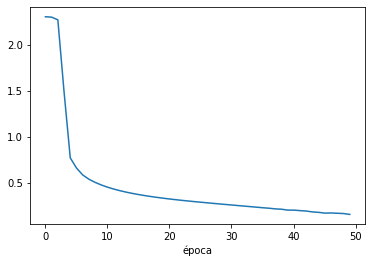

In [100]:
n_batches_train = len(loader_train)
plt.plot(epochs[::n_batches_train], loss_history[::n_batches_train])
plt.xlabel('época')

In [101]:
loss_epoch_end

[2.3058278560638428,
 2.2920193672180176,
 1.6722533702850342,
 0.664764404296875,
 0.51762455701828,
 0.4281214773654938,
 0.3830735683441162,
 0.35477763414382935,
 0.3338231146335602,
 0.3161357641220093,
 0.2999548316001892,
 0.2850281596183777,
 0.2714579701423645,
 0.2593613266944885,
 0.24819475412368774,
 0.23820634186267853,
 0.22875545918941498,
 0.22064208984375,
 0.21267275512218475,
 0.20575863122940063,
 0.19892746210098267,
 0.19281044602394104,
 0.18706578016281128,
 0.18178457021713257,
 0.17690370976924896,
 0.1722036600112915,
 0.16795562207698822,
 0.1637648642063141,
 0.16016444563865662,
 0.15663710236549377,
 0.15282480418682098,
 0.1500665843486786,
 0.146478071808815,
 0.1439305990934372,
 0.14013415575027466,
 0.13885430991649628,
 0.1336461305618286,
 0.13534210622310638,
 0.1272878795862198,
 0.1464318037033081,
 0.1399143785238266,
 0.12297721207141876,
 0.12102048099040985,
 0.12309666723012924,
 0.11458013206720352,
 0.15610045194625854,
 0.13040502369403

In [102]:
# Assert do histórico de losses
target_loss_epoch_end = np.array([
    2.303267478942871,
    2.227701187133789,
    1.0923893451690674,
    0.5867354869842529,
    0.5144089460372925,
    0.45026642084121704,
    0.4075140357017517,
    0.37713879346847534,
    0.3534485101699829,
    0.3341451585292816,
    0.3181140422821045,
    0.30457887053489685,
    0.29283496737480164,
    0.2827608287334442,
    0.2738332152366638,
    0.2657742500305176,
    0.2583288848400116,
    0.25117507576942444,
    0.24439716339111328,
    0.23789969086647034,
    0.23167723417282104,
    0.22562651336193085,
    0.21984536945819855,
    0.2142913043498993,
    0.20894232392311096,
    0.203872948884964,
    0.19903430342674255,
    0.19439971446990967,
    0.18994088470935822,
    0.18563991785049438,
    0.18147490918636322,
    0.17744913697242737,
    0.17347246408462524,
    0.16947467625141144,
    0.16547319293022156,
    0.16150487959384918,
    0.1574639081954956,
    0.1534043848514557,
    0.14926929771900177,
    0.1452063024044037,
    0.1412365883588791,
    0.13712672889232635,
    0.1331038922071457,
    0.1291467249393463,
    0.1251506358385086,
    0.12116757035255432,
    0.11731722950935364,
    0.11364627629518509,
    0.11001908034086227,
    0.10655981302261353])

assert np.allclose(np.array(loss_epoch_end), target_loss_epoch_end, atol=1e-6)

AssertionError: ignored